This is a notebook with all experiments in the DEDPUL paper on behcnmark data sets: UCI, MNIST, CIFAR-10.

At the end of the notebook you can play with DEDPUL on specific data sets.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, laplace
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
%matplotlib inline
from IPython import display

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, log_loss, mean_absolute_error, mean_squared_error, brier_score_loss
from sklearn.metrics import precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

from scipy.stats import linregress
from scipy.optimize import minimize
from scipy.stats import t
from statsmodels.stats.multitest import multipletests

from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping

from algorithms import *
from utils import *
from KMPE import *
from NN_functions import *

from torchvision.datasets import MNIST

from tqdm import tqdm_notebook as tqdm
# from tqdm import tqdm as tqdm

import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: F

# Data

In [2]:
def read_data(data_mode, truncate=None, random_state=None):
    if data_mode == 'bank':
        df = pd.read_csv('UCI//bank//bank-full.csv', sep=';')
        df['balance'] = normalize_col(df['balance'])
        df = dummy_encode(df)
        df.rename(columns={'y': 'target'}, inplace=True)

    elif data_mode == 'concrete':
        df = pd.read_excel('UCI//concrete//Concrete_Data.xls')
        df = normalize_cols(df)
        df.rename(columns={'Concrete compressive strength(MPa, megapascals) ': 'target'}, inplace=True)
        df['target'] = reg_to_class(df['target'])

    elif data_mode == 'housing':
        df = pd.read_fwf('UCI//housing//housing.data.txt', header=None)
        df = normalize_cols(df)
        df.rename(columns={13: 'target'}, inplace=True)
        df['target'] = reg_to_class(df['target'])

    elif data_mode == 'landsat':
        df = pd.read_csv('UCI//landsat//sat.trn.txt', header=None, sep=' ')
        df = pd.concat([df, pd.read_csv('UCI//landsat//sat.tst.txt', header=None, sep=' ')])
        df = normalize_cols(df, columns=[x for x in range(36)])
        df.rename(columns={36: 'target'}, inplace=True)
        df['target'] = mul_to_bin(df['target'])

    elif data_mode == 'mushroom':
        df = pd.read_csv('UCI//mushroom//agaricus-lepiota.data.txt', header=None)
        df = dummy_encode(df)
        df.rename(columns={0: 'target'}, inplace=True)

    elif data_mode == 'pageblock':
        df = pd.read_fwf('UCI//pageblock//page-blocks.data', header=None)
        df = normalize_cols(df, columns=[x for x in range(10)])
        df.rename(columns={10: 'target'}, inplace=True)
        df['target'] = mul_to_bin(df['target'], 1)

    elif data_mode == 'shuttle':
        df = pd.read_csv('UCI//shuttle//shuttle.trn', header=None, sep=' ')
        df = pd.concat([df, pd.read_csv('UCI//shuttle//shuttle.tst.txt', header=None, sep=' ')])
        df = normalize_cols(df, columns=[x for x in range(9)])
        df.rename(columns={9: 'target'}, inplace=True)
        df['target'] = mul_to_bin(df['target'], 1)

    elif data_mode == 'spambase':
        df = pd.read_csv('UCI//spambase//spambase.data.txt', header=None, sep=',')
        df = normalize_cols(df, columns=[x for x in range(57)])
        df.rename(columns={57: 'target'}, inplace=True)

    elif data_mode == 'wine':
        df = pd.read_csv('UCI//wine//winequality-red.csv', sep=';')
        df_w = pd.read_csv('UCI//wine//winequality-white.csv', sep=';')
        df['target'] = 1
        df_w['target'] = 0
        df = pd.concat([df, df_w])
        df = normalize_cols(df, [x for x in df.columns if x != 'target'])
        
    elif data_mode.startswith('mnist'):
        data = MNIST('mnist', download=True, train=True)
        data_test = MNIST('mnist', download=True, train=False)

        df = data.train_data
        target = data.train_labels
        df_test = data_test.test_data
        target_test = data_test.test_labels

        df = pd.DataFrame(torch.flatten(df, start_dim=1).detach().numpy())
        df_test = pd.DataFrame(torch.flatten(df_test, start_dim=1).detach().numpy())
        df = pd.concat([df, df_test])
        df = normalize_cols(df)
        
        target = pd.Series(target.detach().numpy())
        target_test = pd.Series(target_test.detach().numpy())
        target = pd.concat([target, target_test])
        
        if data_mode == 'mnist_1':
            target[target % 2 == 0] = 0
            target[target != 0] = 1
        elif data_mode == 'mnist_2':
            target[target < 5] = 0
            target[target >= 5] = 1
        elif data_mode == 'mnist_3':
            target[target.isin({0, 3, 5, 6, 7})] = 0
            target[target.isin({1, 2, 4, 8, 9})] = 1
        
        df['target'] = target
    
    elif data_mode.startswith('cifar10'):
        
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)
#         trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
#                                                   shuffle=True, num_workers=2)
        
        data = trainset.data
        target = trainset.targets
#         if truncate is not None and truncate < trainset.data.shape[0]:
#             np.random.seed(random_state)
#             mask = np.random.choice(np.arange(trainset.data.shape[0]), truncate, replace=False)
#             np.random.seed(None)
#             data = trainset.data[mask]
#             target = trainset.targets[mask]
        data = data / 128 - 1

        classes = ('plane', 'car', 'bird', 'cat',
                   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        target = pd.Series(target)
        target[target.isin([0, 1, 8, 9])] = 1
        target[target != 1] = 0
        
        df = pd.DataFrame(data.reshape(data.shape[0], -1))
        df['target'] = target
        
    # 1 = N, 0 = P
    df['target'] = 1 - df['target']
    
    if truncate is not None and truncate < df.shape[0]:
        if truncate > 1:
            df = df.sample(n=truncate, random_state=random_state)
        elif truncate > 0:
            df = df.sample(frac=truncate, random_state=random_state)
    return df

In [3]:
def make_pu(df, data_mode, alpha=0.5, random_state=None):
    df['target_pu'] = df['target']
    n_pos, n_pos_to_mix, n_neg_to_mix = shapes[data_mode][alpha]
    df_pos = df[df['target'] == 0].sample(n=n_pos+n_pos_to_mix, random_state=random_state, replace=False).reset_index(drop=True)
    df_neg = df[df['target'] == 1].sample(n=n_neg_to_mix, random_state=random_state, replace=False).reset_index(drop=True)
    df_pos.loc[df_pos.sample(n=n_pos_to_mix, random_state=random_state, replace=False).index, 'target_pu'] = 1
    return pd.concat([df_pos, df_neg]).sample(frac=1).reset_index(drop=True)

In [4]:
shapes = {'bank': {0.95: (1000, int(39922 / 19), 39922), 
                   0.75: (1000, 4289, 4289*3), 
                   0.50: (1000, 4289, 4289), 
                   0.25: (1000, 4289, int(4289 / 3)), 
                   0.05: (1000, 4289, int(4289 / 19))},
          'concrete': {0.95: (100, int(540 / 19), 540), 
                   0.75: (100, 180, 540), 
                   0.50: (100, 390, 390), 
                   0.25: (100, 390, 130),
                   0.05: (100, 380, 20)},
          'housing': {0.95: (194, 15, 297), 
                   0.75: (110, 99, 297), 
                   0.50: (50, 159, 159),
                   0.25: (50, 159, 53),
                   0.05: (57, 152, 8)},
          'landsat': {0.95: (1000, 189, 3594), 
                   0.75: (1000, 1000, 3000), 
                   0.50: (1000, 1841, 1841), 
                   0.25: (1000, 1841, int(1841 / 3)), 
                   0.05: (1000, 1841, int(1841 / 19))},
          'mushroom': {0.95: (1000, 200, 3800), 
                   0.75: (1000, 1000, 3000), 
                   0.50: (1000, 2000, 2000), 
                   0.25: (1000, 2916, 972), 
                   0.05: (990, 2926, 154)},
          'pageblock': {0.95: (100, 234, 4446), 
                   0.75: (100, 460, 1380), 
                   0.50: (100, 460, 460), 
                   0.25: (101, 459, 153), 
                   0.05: (104, 456, 24)},
          'shuttle': {0.95: (1000, int(45586 / 19), 45586), 
                   0.75: (1000, 11414, 11414 * 3), 
                   0.50: (1000, 11414, 11414), 
                   0.25: (1000, 11414, int(11414 / 3)), 
                   0.05: (1000, 11414, int(11414 / 19))},
          'spambase': {0.95: (400, 147, 2788), 
                   0.75: (400, 929, 2788), 
                   0.50: (400, 1413, 1413), 
                   0.25: (400, 1413, 471), 
                   0.05: (407, 1406, 74)},
          'wine': {0.95: (500, int(4898 / 19), 4898), 
                   0.75: (500, 1099, 1099 * 3), 
                   0.50: (500, 1099, 1099), 
                   0.25: (500, 1099, int(1099 / 3)), 
                   0.05: (500, 1099, int(1099 / 19))},
          'mnist_1': {0.95: (1000, int(34418 / 19), 34418), 
                   0.75: (1000, int(34418 / 3), 34418), 
                   0.50: (1000, 34418, 34418), 
                   0.25: (1000, 34582, int(34582 / 3)), 
                   0.05: (1000, 34582, int(34582 / 19))},
          'cifar10': {0.95: (1000, int(30000 / 19), 30000), 
                   0.75: (1000, 10000, 30000), 
                   0.50: (1000, 19000, 19000), 
                   0.25: (1000, 19000, int(19000 / 3)), 
                   0.05: (1000, 19000, int(19000 / 19))}}

LRS = {
    'bank': 5e-4,
    'concrete': 1e-4,
    'housing': 1e-4,
    'landsat': 1e-5,
    'mushroom': 1e-4,
    'pageblock': 1e-4,
    'shuttle': 1e-4,
    'spambase': 1e-5,
    'wine': 5e-5,
    'mnist_1': 1e-4,
    'mnist_2': 1e-4,
    'mnist_3': 1e-4,
    'cifar10': 1e-4,
}

# DEDPUL, EN, and nnPU

In [5]:
def experiment_uci(datasets=None, alphas=None, n_networks=1, n_rep=10, find_alpha=False):
    
    if alphas is None:
        alphas = [0.05, 0.25, 0.5, 0.75, 0.95]
        
    if datasets is None:
        datasets = [
                    'bank', 'concrete', 'mushroom', 'pageblock', 'landsat', 'shuttle', 'spambase', 'wine',
                    'mnist_1', 
                    'cifar10',
        ]
    
    results = []
    fixed_alpha = None
    for dataset in tqdm(datasets):

        for alpha in tqdm(shapes[dataset].keys()):
        
            if alpha not in alphas:
                continue
            
            n_pos, n_pos_to_mix, n_neg_to_mix = shapes[dataset][alpha]
            n_mix = n_pos_to_mix + n_neg_to_mix
            real_alpha = n_neg_to_mix / n_mix
            
            for i in tqdm(range(n_rep)):
        
                df = read_data(dataset, truncate=None, random_state=i)
               
                df = make_pu(df, dataset, alpha, random_state=i)
                data = df.drop(['target', 'target_pu'], axis=1).values
                all_conv = False
                n_neurons = 512
                if dataset == 'cifar10':
                    data = np.swapaxes(data.reshape(data.shape[0], 32, 32, 3), 1, 3)
                    all_conv = True
                    n_neurons = 128
            
                target_pu = df['target_pu'].values
                target_mix = df.loc[df['target_pu'] == 1, 'target'].values
                
                if not find_alpha:
                    fixed_alpha = real_alpha
                res = dict()
                
                try:
                    res = estimate_poster_cv(data, target_pu, estimator='ntc_methods', alpha=fixed_alpha,
                                             estimate_poster_options={'disp': False, 'alpha_as_mean_poster': True},
                                            estimate_diff_options={
                                                 'MT': False, 'MT_coef': 0.25, 'decay_MT_coef': False, 'tune': False,
                                                 'bw_mix': 0.05, 'bw_pos': 0.1, 'threshold': 'mid', 
                                                 'n_gauss_mix': 20, 'n_gauss_pos': 10,
                                                 'bins_mix': 20, 'bins_pos': 20, 'k_neighbours': None,},
                                             estimate_preds_cv_options={
                                                 'n_networks': n_networks,
                                                 'cv': 5,
                                                 'random_state': i*n_networks,
                                                 'hid_dim': n_neurons,
                                                 'n_hid_layers': 1,
                                                 'lr': LRS[dataset],
                                                 'l2': 1e-4,
                                                 'bn': True,
                                                 'all_conv': all_conv,
                                             },
                                             train_nn_options = {
                                                 'n_epochs': 250, 'loss_function': 'log', 'batch_size': 64,
                                                 'n_batches': None, 'n_early_stop': 7, 'disp': False,
                                             },
                                         
                                             ### catboost
#                                              estimate_preds_cv_options={
#                                                  'n_networks': n_networks,
#                                                  'cv': 5,
#                                                  'random_state': i*n_networks,
#                                                  'n_early_stop': 25,
#                                                  'catboost_params': {
#                                                      'iterations': 500, 'depth': 8, 'learning_rate': 0.02, 
#                                                      'l2_leaf_reg': 10, 
#                                                  },
#                                              },
                                             
                                            )

                    res['nnre_sigmoid'] = estimate_poster_cv(
                        data, target_pu, estimator='nnre', alpha=real_alpha, 
                        estimate_preds_cv_options={
                            'n_networks': n_networks,
                            'cv': 5,
                            'random_state': i*n_networks,
                            'hid_dim': n_neurons,
                            'n_hid_layers': 1,
                            'lr': LRS[dataset],
                            'l2': 1e-4,
                            'bn': True,
                            'all_conv': all_conv,
                        },
                        train_nn_options = {
                            'n_epochs': 250, 'loss_function': 'sigmoid', 'batch_size': 64,
                            'n_batches': None, 'n_early_stop': 10, 'disp': False,
                            'beta': 0, 'gamma': 1,
                        },
                    )
                    
                    res['nnre_brier'] = estimate_poster_cv(
                        data, target_pu, estimator='nnre', alpha=real_alpha, 
                        estimate_preds_cv_options={
                            'n_networks': n_networks,
                            'cv': 5,
                            'random_state': i*n_networks,
                            'hid_dim': n_neurons,
                            'n_hid_layers': 1,
                            'lr': LRS[dataset],
                            'l2': 1e-4,
                            'bn': True,
                            'all_conv': all_conv,
                        },
                        train_nn_options = {
                            'n_epochs': 250, 'loss_function': 'brier', 'batch_size': 64,
                            'n_batches': None, 'n_early_stop': 10, 'disp': False,
                            'beta': 0, 'gamma': 1,
                        },
                    )

                except:
                    print(f'dataset = {dataset}, i = {i} failed')
                    continue
                for key in res.keys():
                    est_alpha, poster = res[key]

                    cur_result = [dataset, key, i, n_mix, n_pos, alpha, real_alpha, est_alpha]
                    if poster is not None:
                        cur_result.append(np.mean(poster))
                        cur_result.append(accuracy_score(target_mix, poster.round()))
                        cur_result.append(roc_auc_score(target_mix, poster))
                        cur_result.append(log_loss(target_mix, poster))
                        cur_result.append(precision_score(target_mix, poster.round()))
                        cur_result.append(recall_score(target_mix, poster.round()))
                        cur_result.append(balanced_accuracy_score(target_mix, poster.round()))
                        cur_result.append(brier_score_loss(target_mix, poster))
                    results.append(cur_result)
                
    df_results = pd.DataFrame(results, columns=['dataset', 'estimator', 'random_state', 
                                                'n_mix', 'n_pos', 'alpha', 'real_alpha', 'est_alpha', 'mean_poster',
                                                'accuracy', 'roc', 'log_loss', 'precision', 'recall', 
                                                'accuracy_balanced', 'brier_score',]) 
    return df_results

In [5]:
res = experiment_uci()
res = res.round(5)

res.to_csv('exp_uci_new.csv', index=False, sep=';', decimal=',')

# KMPE

In [99]:
def experiment_uci_KM(datasets=None, alphas=None, n_rep=10, max_sample=4000):
    
    if alphas is None:
        alphas = [0.05, 0.25, 0.5, 0.75, 0.95]
        
    if datasets is None:
        datasets = ['bank', 'concrete', 'landsat', 'mushroom', 'pageblock', 'shuttle', 'spambase', 'wine',
                   'mnist_1',
                   'cifar10',]
        
    results = []
    for dataset in tqdm(datasets):            

        for alpha in tqdm(shapes[dataset].keys()):
        
            if alpha not in alphas:
                continue
            
            n_pos, n_pos_to_mix, n_neg_to_mix = shapes[dataset][alpha]
            n_mix = n_pos_to_mix + n_neg_to_mix
            real_alpha = n_neg_to_mix / n_mix
            
            for i in tqdm(range(n_rep)):
        
                df = read_data(dataset, truncate=None, random_state=i)
                df = make_pu(df, dataset, alpha, random_state=i)
            
                if dataset in {'mnist_1', 'mnist_2', 'mnist_3', 'cifar10'}:
                    pca = PCA(50)
                    data = pca.fit_transform(df.drop(['target', 'target_pu'], axis=1).values)
                else:
                    data = df.drop(['target', 'target_pu'], axis=1).values
            
                target_pu = df['target_pu'].values
                target_mix = df.loc[df['target_pu'] == 1, 'target'].values
                
                data_pos = data[target_pu == 0]
                data_mix = data[target_pu == 1][np.random.randint(0, int(target_pu.sum()), 
                                                                  min(max_sample - int((1-target_pu).sum()),
                                                                      int(target_pu.sum())))]
                try:
                    KM_2 = 1 - wrapper(data_mix, data_pos, disp=False, 
                                        KM_1=False, KM_2=True, lambda_lower_bound=0.5, lambda_upper_bound=10)
                except ValueError as e:
                    KM_2 = np.NaN
                    print(e)
                
                cur_result = [dataset, i, n_mix, n_pos, alpha, real_alpha, KM_2] 
                results.append(cur_result)
                
    df_results = pd.DataFrame(results, columns=['dataset', 'random_state', 'n_mix', 'n_pos', 'alpha', 'real_alpha', 
                                                'est_alpha'])
    df_results['estimator'] = 'KM'
    return df_results

In [16]:
res_KM = experiment_uci_KM(datasets=None, alphas=None, n_rep=10)

res_KM = res_KM.round(5)
res_KM.to_csv('exp_KMPE_uci.csv', index=False, sep=';', decimal=',')

# TIcE

In [57]:
from TIcE import tice, tice_c_to_alpha, min_max_scale

def experiment_uci_TIcE(datasets=None, alphas=None, n_rep=10, NTC=False):
    
    if alphas is None:
        alphas = [0.05, 0.25, 0.5, 0.75, 0.95]
        
    if datasets is None:
        datasets = [
                    'bank', 'concrete', 'mushroom', 
                    'landsat', 'pageblock', 'shuttle', 'spambase', 'wine',
                    'mnist_1', 
                    'cifar10'
        ]
    results = []
    for dataset in tqdm(datasets):            

        for alpha in tqdm(shapes[dataset].keys()):
        
            if alpha not in alphas:
                continue
            
            n_pos, n_pos_to_mix, n_neg_to_mix = shapes[dataset][alpha]
            n_mix = n_pos_to_mix + n_neg_to_mix
            real_alpha = n_neg_to_mix / n_mix
            
            for i in tqdm(range(n_rep)):
        
                df = read_data(dataset, truncate=None, random_state=i)
                df = make_pu(df, dataset, alpha, random_state=i)
                data = df.drop(['target', 'target_pu'], axis=1).values
            
                target_pu = df['target_pu'].values
                target_mix = df.loc[df['target_pu'] == 1, 'target'].values
                gamma = target_pu.sum() / target_pu.shape[0]
                
                if NTC:
                    if dataset == 'cifar10':
                        data = np.swapaxes(data.reshape(data.shape[0], 32, 32, 3), 1, 3)
                    data = estimate_preds_cv(
                                data, target_pu, cv=5, all_conv=(dataset == 'cifar10'),
                                n_networks=1, hid_dim=512, n_hid_layers=1, lr=LRS[dataset], bn=True, l2=1e-4,
                                train_nn_options={'n_epochs': 200, 'metric': roc_auc_loss, 'batch_size': 64,
                                                  'n_batches': None, 'n_early_stop': 10, 'disp': False, 
                                                  'loss_function': 'log'}).reshape(-1, 1)
                else:
                    if dataset in {'mnist_1', 'mnist_2', 'mnist_3', 'cifar10'}:
                        pca = PCA(200)
                        data = pca.fit_transform(data)
                    data = min_max_scale(data)
                    
                
                c = tice(data, 1 - target_pu, 10, np.random.randint(5, size=len(data)),
                         delta=.2 maxSplits=500, minT=10, n_splits=3)[0]
                alpha_tice = tice_c_to_alpha(c, gamma)
                
                cur_result = [dataset, i, n_mix, n_pos, alpha, real_alpha, alpha_tice] 
                results.append(cur_result)
                
    df_results = pd.DataFrame(results, columns=['dataset', 'random_state', 'n_mix', 'n_pos', 'alpha', 'real_alpha', 
                                                'est_alpha'])
   
    df_results['estimator'] = 'tice'
    return df_results

In [17]:
res_tice = experiment_uci_TIcE(NTC=False, n_rep=10)
res_tice = res_tice.round(5)
res_tice['est_alpha'][res_tice['est_alpha'] < 0] = 0
res_tice.to_csv('TIcE_uci.csv', index=False, sep=';', decimal=',')

# The data set with all results

In [6]:
# this is a merged data set with all experiments with all methods
res = pd.read_csv('exp_uci_new_merged.csv', sep=';', decimal=',')

In [7]:
res['alpha_mae'] = (res['real_alpha'] - res['est_alpha']).abs()
res_grouped = res.groupby(['dataset', 'n_mix', 'n_pos', 'alpha', 'estimator']).mean().drop(
    ['est_alpha', 'random_state'], axis=1).reset_index()

res_pivot_alpha = res_grouped.pivot_table(index=['dataset', 'alpha'], columns=['estimator'], values='alpha_mae')

metric = 'accuracy'
res_pivot_roc = res_grouped.pivot_table(index=['dataset', 'alpha'], columns=['estimator'], values=metric)
res_pivot_roc = 1 - res_pivot_roc
res_pivot_roc = clean_columns_poster(res_pivot_roc)

In [8]:
res_pivot_alpha.reset_index(inplace=True)
res_pivot_alpha.loc[res_pivot_alpha['dataset'] == 'mnist_1', 'dataset'] = 'mnist'
res_pivot_alpha.set_index(['dataset', 'alpha'], inplace=True)

In [9]:
res_pivot_roc.reset_index(inplace=True)
res_pivot_roc.loc[res_pivot_roc['dataset'] == 'mnist_1', 'dataset'] = 'mnist'
res_pivot_roc.set_index(['dataset', 'alpha'], inplace=True)

# Plots

In [13]:
# To switch between comparison of DEDPUL with SOTA and ablations of DEDPUL, comment lines under #1 and 
# uncomment lines under #2

def plot_results_uci(res_plt, datasets=None, ylims=None, reverse_alpha=False, save_name=None, dpi=200,
                      alpha_mode=True):
    
    if reverse_alpha:
        # by default all estimates are computed for negative priors; here convert them to positive priors
        res_plt['alpha'] = 1 - res_plt['alpha']
     
    if ylims is None:
        ylims = dict()
        
    if datasets is None:
        datasets = ['bank', 'concrete', 'mushroom', 'landsat', 'pageblock', 'shuttle',
                    'spambase', 'wine', 'mnist', 'cifar10']
        
    fig = plt.figure(0)
    fig.set_size_inches(w=35, h=14)

    for i in range(10):
        try:
            dataset = datasets[i]
        except:
            break
        res_plt_cur = res_plt[res_plt['dataset'] == dataset]
        plt.subplot2grid((2, 5), (i//5,i%5), colspan=1, rowspan=1)
        plt.title(dataset, fontdict={'fontsize': 23})
        
        if not alpha_mode:
            pass
            # 1
            plt.plot(res_plt_cur['alpha'], res_plt_cur['nnre_brier'], color='purple', marker='v', ls='--')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['nnre_sigmoid'], color='brown', marker='^', ls='-.')
        else:
            pass
            # 1
            plt.plot(res_plt_cur['alpha'], res_plt_cur['KM'], 'rs--')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['tice'], c='g', marker='v', ls='-.')
            plt.plot(res_plt_cur['alpha'], res_plt_cur['tice+ntc'], c='b', marker='*', ls='-.')
            # 2
#             plt.plot(res_plt_cur['alpha'], res_plt_cur['baseline_dedpul'], c='r', marker='*', ls='--')

        plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul'], 'ko-')
        # 1
        plt.plot(res_plt_cur['alpha'], res_plt_cur['e1_en'], c='orange', marker='x', ls=':')
        # 2
#         plt.plot(res_plt_cur['alpha'], res_plt_cur['cat'], c='g', marker='*', ls='--')
#         plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul_GMM'], c='purple', marker='*', ls='-.')
#         plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul_hist'], c='b', marker='*', ls='-.')
#         plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul_no_heur'], c='darkcyan', marker='*', ls=':')

        plt.xlim(0, 1)
        plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], fontsize='xx-large')
        plt.xticks(res_plt_cur['alpha'].unique(), fontsize='xx-large')
        if dataset in ylims.keys():
            plt.ylim(0, ylims[dataset])

        if i >= 5:
            plt.xlabel(r'$\alpha$', fontsize='xx-large')
        if i% 5 == 0:
            if not alpha_mode:
                plt.ylabel('1 - accuracy', fontsize='xx-large')
            else:
                plt.ylabel(r'$\left|\alpha - \widetilde{\alpha}^*\right|$', fontsize='xx-large')

        if dataset == 'mushroom':
            if not alpha_mode:
                # 1
                plt.legend(handles=(Line2D([], [], linestyle=':', color='orange', marker='x'),
                                    Line2D([], [], color='purple', marker='v', ls='--'),
                                    Line2D([], [], color='brown', marker='^', ls='-.'),
                                    Line2D([], [], linestyle='-', color='k', marker='o')),
                          labels=('EN', 'nnPU-brier', 'nnPU-sigmoid', 'DEDPUL'), loc='upper left', fontsize='xx-large')

                # 2
#                 plt.legend(handles=(Line2D([], [], linestyle='-', color='k', marker='o'),
#                                     Line2D([], [], linestyle='--', color='g', marker='*'),
#                                     Line2D([], [], linestyle='-.', color='purple', marker='*'),
#                                     Line2D([], [], linestyle='-.', color='b', marker='*'),
#                                     Line2D([], [], linestyle=':', color='darkcyan', marker='*')),
#                           labels=('DEDPUL', 'catboost', 'GMM', 'hist', 'no_smooth'), 
#                            loc='upper left', fontsize='xx-large')
            else:
                # 1
                plt.legend(handles=(Line2D([], [], linestyle=':', color='orange', marker='x'),
                                    Line2D([], [], c='g', marker='v', ls='-.'),
                                    Line2D([], [], c='b', marker='*', ls='-.'),
                                    Line2D([], [], linestyle='--', color='r', marker='s'),
                                    Line2D([], [], linestyle='-', color='k', marker='o'),
                ),
                           labels=('EN', 'TIcE', 'NTC+TIcE', 'KM2', 'DEDPUL'), 
                           loc='upper left', fontsize='xx-large')
             
                # 2
#                 plt.legend(handles=(Line2D([], [], linestyle='-', color='k', marker='o'),
#                                     Line2D([], [], linestyle='--', color='r', marker='*'),
#                                     Line2D([], [], linestyle='--', color='g', marker='*'),
#                                     Line2D([], [], linestyle='-.', color='purple', marker='*'),
#                                     Line2D([], [], linestyle='-.', color='b', marker='*'),
#                                     Line2D([], [], linestyle=':', color='darkcyan', marker='*')),
#                           labels=('DEDPUL', 'simple_alpha', 'catboost', 'GMM', 'hist', 'no_smooth'), 
#                            loc='upper center', fontsize='xx-large')
                
        
    if save_name:
        plt.savefig(save_name + '.png', dpi=dpi)

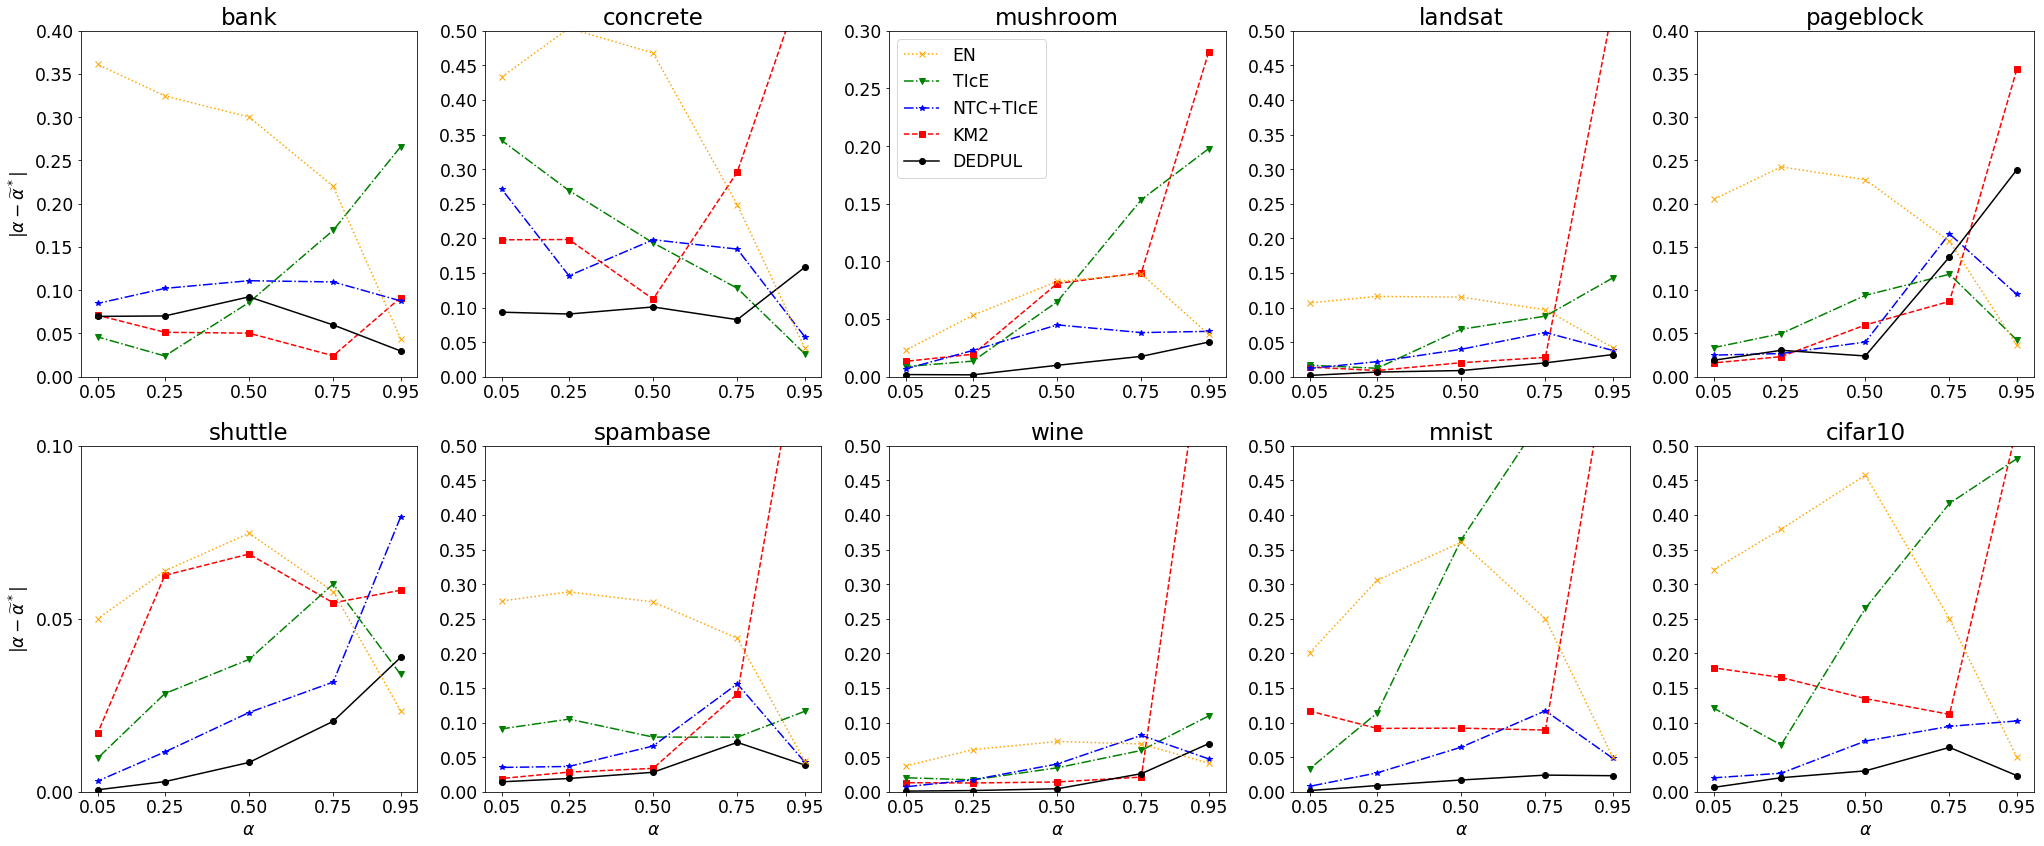

In [14]:
plot_results_uci(res_pivot_alpha.copy().reset_index(), reverse_alpha=True, alpha_mode=True,
                       ylims={'bank': 0.4,
                              'concrete': 0.5,
                              'landsat': 0.5,
                              'mushroom': 0.3,
                              'pageblock': 0.4,
                              'shuttle': 0.1,
                              'spambase': 0.5,
                              'wine': 0.5,
                              'mnist': 0.5,
                              'cifar10': 0.5},
# #                 save_name='uci_alpha_new',
#                        ylims={'bank': 0.2,
#                               'concrete': 0.45,
#                               'landsat': 0.16,
#                               'mushroom': 0.3,
#                               'pageblock': 0.5,
#                               'shuttle': 0.2,
#                               'spambase': 0.25,
#                               'wine': 0.35,
#                               'mnist': 0.15,
#                               'cifar10': 0.25},
# #                  save_name='uci_alpha_new_ablation',
                )

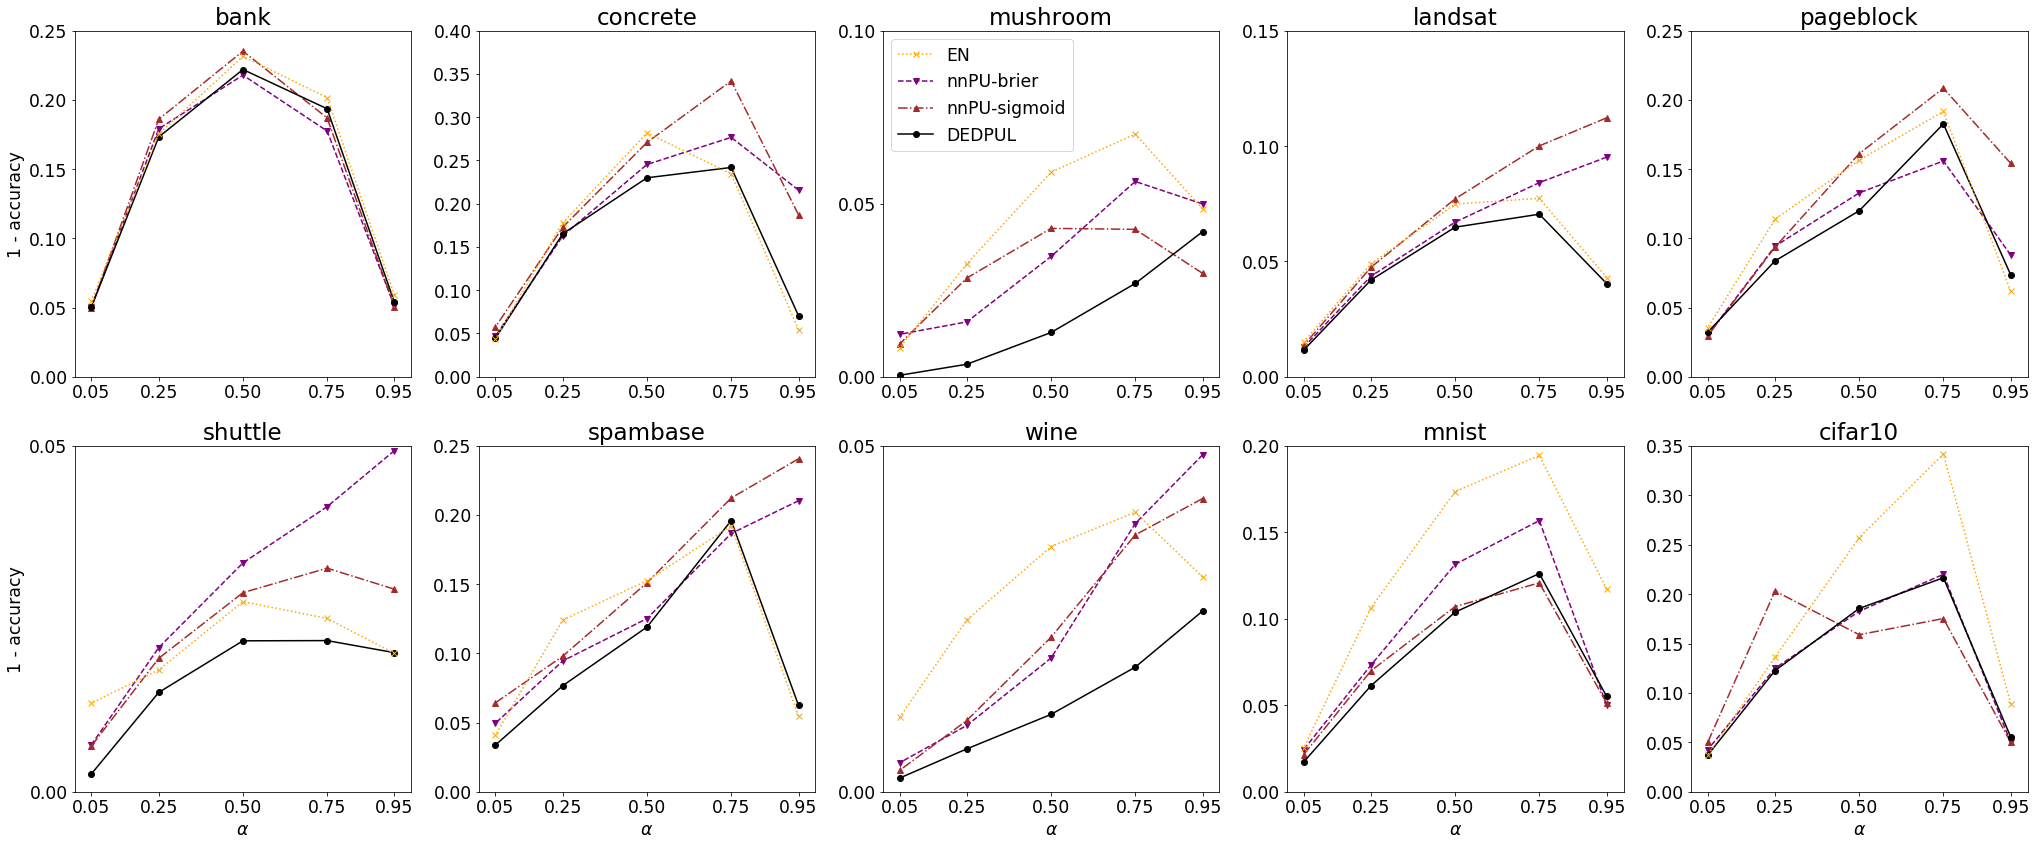

In [15]:
plot_results_uci(res_pivot_roc.copy().reset_index(), reverse_alpha=True, alpha_mode=False,
                        ylims={'bank': 0.25,
                              'concrete': 0.4,
                              'landsat': 0.15,
                              'mushroom': 0.1,
                              'pageblock': 0.25,
                              'shuttle': 0.05,
                              'spambase': 0.25,
                              'wine': 0.05,
                              'mnist': 0.2,
                              'cifar10': 0.35},
# #                 save_name='uci_ac_new',
#                         ylims={'bank': 0.25,
#                               'concrete': 0.3,
#                               'landsat': 0.1,
#                               'mushroom': 0.05,
#                               'pageblock': 0.2,
#                               'shuttle': 0.05,
#                               'spambase': 0.2,
#                               'wine': 0.05,
#                               'mnist': 0.15,
#                               'cifar10': 0.25},
# #                  save_name='uci_ac_new_ablation',
                )

# DEDPUL on specific single data sets

In [18]:
# data_mode = 'bank' # 0.11, (5289, 39922, 45211)
# data_mode = 'concrete' # 0.47, (490, 540, 1030)
# data_mode = 'housing' # 0.41, (209, 297, 506)
# data_mode = 'landsat' # 0.44, (2841, 3594, 6435)
data_mode = 'mushroom' # 0.48, (3916, 4208, 8124)
# data_mode = 'pageblock' # 0.1, (560, 4913, 5473)
# data_mode = 'shuttle' # 0.21, (12414, 45586, 58000)
# data_mode = 'spambase' # 0.39, (1813, 2788, 4601)
# data_mode = 'wine' # 0.24, (1599, 4898, 6497)
# data_mode = 'mnist_1' # 0.51, (35582, 34418, 70000)
# data_mode = 'cifar10' # 0.4, (20000, 30000, 50000)

In [19]:
alpha = 0.25
df = read_data(data_mode, truncate=None)
df = make_pu(df, data_mode, alpha=alpha, random_state=None)
alpha = ((df['target'] == 1).sum() / (df['target_pu'] == 1).sum()).item()
gamma = (df['target_pu'] == 1).sum() / df.shape[0]

print(df.shape)
print('alpha =', alpha)

(4888, 24)
alpha = 0.25


In [20]:
data = df.drop(['target', 'target_pu'], axis=1).values
all_conv = False
if data_mode == 'cifar10':
    data = np.swapaxes(data.reshape(data.shape[0], 32, 32, 3), 1, 3)
    all_conv = True
target = df['target_pu'].values

preds = estimate_preds_cv(data, target, cv=3, bayes=False, random_state=42, all_conv=all_conv,
                          n_networks=1, hid_dim=512, n_hid_layers=1, lr=LRS[data_mode], l2=1e-4, bn=True,
                          train_nn_options={'n_epochs': 500, 'bayes_weight': 1e-5,
                                            'batch_size': 64, 'n_batches': None, 'n_early_stop': 7, 
                                            'disp': True, 'loss_function': 'log',
                                            'metric': roc_auc_loss, 'stop_by_metric': False})

# preds = estimate_preds_cv_catboost(
#     data, target, cv=5, n_networks=1, random_state=42, n_early_stop=20, verbose=True,
#     catboost_params={
#         'iterations': 500, 'depth': 8, 'learning_rate': 0.02, 'l2_leaf_reg': 10,
#     },
# )

print('ac', accuracy_score(df['target_pu'], preds.round()))
# print('bac', balanced_accuracy_score(df['target_pu'], preds.round()))
print('roc', roc_auc_score(df['target_pu'], preds))
print('brier', brier_score_loss(df['target_pu'], preds))

epoch 0 , train_loss= 0.67603 , test_loss= 0.68833 test_metric= -0.5679150957344571
epoch 1 , train_loss= 0.66451 , test_loss= 0.67969 test_metric= -0.5921675168182154
epoch 2 , train_loss= 0.6482 , test_loss= 0.67227 test_metric= -0.6031247689805574
epoch 3 , train_loss= 0.64124 , test_loss= 0.66373 test_metric= -0.6165077252901604
epoch 4 , train_loss= 0.64017 , test_loss= 0.65882 test_metric= -0.6173093627559696
epoch 5 , train_loss= 0.63476 , test_loss= 0.65557 test_metric= -0.6182057181932431
epoch 6 , train_loss= 0.63096 , test_loss= 0.64686 test_metric= -0.63321736157315
epoch 7 , train_loss= 0.61831 , test_loss= 0.64294 test_metric= -0.6397644525763289
epoch 8 , train_loss= 0.60914 , test_loss= 0.6434 test_metric= -0.6367427182671694
epoch 9 , train_loss= 0.62164 , test_loss= 0.64453 test_metric= -0.6317203555851261
epoch 10 , train_loss= 0.61785 , test_loss= 0.64061 test_metric= -0.6339127300953649
epoch 11 , train_loss= 0.62026 , test_loss= 0.63475 test_metric= -0.64384425593

epoch 7 , train_loss= 0.6302 , test_loss= 0.64498 test_metric= -0.6110369628888147
epoch 8 , train_loss= 0.62675 , test_loss= 0.64426 test_metric= -0.6116208801393986
epoch 9 , train_loss= 0.61798 , test_loss= 0.64266 test_metric= -0.610140232825418
epoch 10 , train_loss= 0.6034 , test_loss= 0.64256 test_metric= -0.6076307789270752
epoch 11 , train_loss= 0.61837 , test_loss= 0.63942 test_metric= -0.614046917287658
epoch 12 , train_loss= 0.61441 , test_loss= 0.63886 test_metric= -0.6126844437029622
epoch 13 , train_loss= 0.58902 , test_loss= 0.64143 test_metric= -0.6105179253327402
epoch 14 , train_loss= 0.60803 , test_loss= 0.63654 test_metric= -0.6129393282171061
epoch 15 , train_loss= 0.60544 , test_loss= 0.63735 test_metric= -0.6071395469543618
epoch 16 , train_loss= 0.6028 , test_loss= 0.63937 test_metric= -0.6006469432395358
epoch 17 , train_loss= 0.5969 , test_loss= 0.63415 test_metric= -0.6127632261891521
epoch 18 , train_loss= 0.60145 , test_loss= 0.63189 test_metric= -0.621116

In [24]:
bw_mix = 0.05
bw_pos = 0.1
MT_coef = 0.25
threshold = (preds[df['target_pu'].values==1].mean()+preds[df['target_pu'].values==0].mean())/2
threshold_h = preds[df['target_pu'].values==1].mean()
threshold_l = preds[df['target_pu'].values==0].mean()
k_neighbours = df.shape[0] // 20

diff = estimate_diff(preds, df['target_pu'].values, bw_mix, bw_pos, 'logit', threshold, k_neighbours,
                     MT=False, MT_coef=MT_coef, tune=False)

In [25]:
test_alpha, poster = estimate_poster_em(diff, mode='dedpul', converge=True, nonconverge=True, 
                                        max_diff=0.05, step=0.0025, alpha_as_mean_poster=True, 
#                                         alpha=alpha,
                                       )

print('alpha:', test_alpha, '\nmean_poster:', np.mean(poster), '\ncons_alpha:', alpha, 
      '\nbaseline alpha:', 1-min(1/diff))

alpha: 0.28013055983015034 
mean_poster: 0.2801323741040724 
cons_alpha: 0.25 
baseline alpha: 0.6289115509149386


In [26]:
# print('log_loss:', 
#       log_loss(df.loc[df['target_pu']==1, 'target'], poster))
print('accuracy:', 
      accuracy_score(df.loc[df['target_pu']==1, 'target'], poster.round()))
print('balanced_accuracy:', 
      balanced_accuracy_score(df.loc[df['target_pu']==1, 'target'], poster.round()))
print('precision:', 
      precision_score(df.loc[df['target_pu']==1, 'target'], poster.round()))
print('recall:', 
      recall_score(df.loc[df['target_pu']==1, 'target'], poster.round()))
print('roc-auc:',
      roc_auc_score(df.loc[df['target_pu']==1, 'target'], poster))
# print('MAE:',
#       mean_absolute_error(df.loc[df['target_pu']==1, 'target'], poster))
# print('RMSE:',
#       np.sqrt(mean_squared_error(df.loc[df['target_pu']==1, 'target'], poster)))

accuracy: 0.9686213991769548
balanced_accuracy: 0.9729080932784637
precision: 0.9017013232514177
recall: 0.9814814814814815
roc-auc: 0.9925983081847279
